# Import dependencies

In [128]:
import time
import json
import itertools
import numpy as np
import pandas as pd

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Data Manipulations
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from imblearn.under_sampling import RandomUnderSampler

# Tuning & Splitting Libraries
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# Loading Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# from xgboost import XGBClassifier

# Model Evaluation Liabraries
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, accuracy_score, r2_score, roc_auc_score, precision_score, recall_score, f1_score

sns.set_style('darkgrid')
sns.color_palette('pastel')



[(0.6313725490196078, 0.788235294117647, 0.9568627450980393),
 (1.0, 0.7058823529411765, 0.5098039215686274),
 (0.5529411764705883, 0.8980392156862745, 0.6313725490196078),
 (1.0, 0.6235294117647059, 0.6078431372549019),
 (0.8156862745098039, 0.7333333333333333, 1.0),
 (0.8705882352941177, 0.7333333333333333, 0.6078431372549019),
 (0.9803921568627451, 0.6901960784313725, 0.8941176470588236),
 (0.8117647058823529, 0.8117647058823529, 0.8117647058823529),
 (1.0, 0.996078431372549, 0.6392156862745098),
 (0.7254901960784313, 0.9490196078431372, 0.9411764705882353)]

# Load data

In [70]:
# Reading text from txt file
with open('../data/origin/transactions.txt') as txt_file:
    lines = txt_file.readlines()

# Text in text file was in JSON format
# Converting text lines to JSON format and then restructuring as a dataframe 
trxn_data = []
for line in lines:
    trxn_data.append(json.loads(line))

# Replacing blank fields with NaN values
df = pd.DataFrame(trxn_data)
df = df.replace(r'', np.NaN)
print('Data has been successfully loaded.')

Data has been successfully loaded.


C:\Users\gorba\AppData\Local\Temp\ipykernel_15488\3961230338.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(r'', np.NaN)


# EDA - exploratory data analyze

In [71]:
df.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000.0,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,02,...,NaN,0.0,NaN,NaN,NaN,False,NaN,NaN,False,False
1,737265056,737265056,5000.0,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,...,NaN,0.0,NaN,NaN,NaN,True,NaN,NaN,False,False
2,737265056,737265056,5000.0,5000.0,2016-11-08T09:18:39,7.47,Play Store,US,US,09,...,NaN,0.0,NaN,NaN,NaN,False,NaN,NaN,False,False
3,737265056,737265056,5000.0,5000.0,2016-12-10T02:14:50,7.47,Play Store,US,US,09,...,NaN,0.0,NaN,NaN,NaN,False,NaN,NaN,False,False
4,830329091,830329091,5000.0,5000.0,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,02,...,NaN,0.0,NaN,NaN,NaN,True,NaN,NaN,False,False


In [72]:
# function to find out base info about dataset
def simple_eda(df):
    total_na = df.isna().sum().sum()
    col_name = df.columns
    dtypes = df.dtypes
    uniq = df.nunique()
    na_val = df.isna().sum()
    duplicate_indices = df[df.duplicated()].index
    print('Dimensions:', df.shape[0], ' - rows', df.shape[1], ' - columns')
    print('Total NA\'s', total_na)
    if len(duplicate_indices) > 0:
        print('Duplicate rows indeces: ', duplicate_indices)
    else:
        print('There are no duplicates in this dataset!') 
    print("%38s %10s     %10s %10s" % ("Column Name", "Data Type", "Count Distinct", "NA Values"))
    for i in range(len(df.columns)):
        print("%38s %10s     %10s %10s" % (col_name[i], dtypes[i], uniq[i], na_val[i]))

In [73]:
simple_eda(df)

Dimensions: 786363  - rows 29  - columns
Total NA's 4728625
There are no duplicates in this dataset!
                           Column Name  Data Type     Count Distinct  NA Values
                         accountNumber     object           5000          0
                            customerId     object           5000          0
                           creditLimit    float64             10          0
                        availableMoney    float64         521916          0
                   transactionDateTime     object         776637          0
                     transactionAmount    float64          66038          0
                          merchantName     object           2490          0
                            acqCountry     object              4       4562
                   merchantCountryCode     object              4        724
                          posEntryMode     object              5       4054
                      posConditionCode     object          

C:\Users\gorba\AppData\Local\Temp\ipykernel_15488\1163208193.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("%38s %10s     %10s %10s" % (col_name[i], dtypes[i], uniq[i], na_val[i]))


## Dataset Column Descriptions:

1. **`accountNumber`**:  
   The account number related to the transaction.

2. **`customerId`**:  
   A unique identifier for the customer.

3. **`creditLimit`**:  
   The credit limit of the customer’s account, indicating the maximum amount they are allowed to spend.

4. **`availableMoney`**:  
   The available funds on the customer’s account at the time of the transaction. `availableMoney=creditLimit−currentBalance`

5. **`transactionDateTime`**:  
   The date and time when the transaction occurred.

6. **`transactionAmount`**:  
   The amount of money involved in the transaction.

7. **`merchantName`**:  
   The name of the merchant where the transaction took place.

8. **`acqCountry`**:  
   The country where the payment instrument (e.g., card) was issued.

9. **`merchantCountryCode`**:  
   The country code of the merchant’s location.

10. **`posEntryMode`**:  
    Describes how the card details were entered at the point of sale (e.g., chip, magnetic stripe, manual entry).

11. **`posConditionCode`**:  
    The condition at the point of sale during the transaction (e.g., whether the card was physically present or not) ???

12. **`merchantCategoryCode`**:  
    A code that represents the category of the merchant’s business (e.g., restaurant, clothing store).

13. **`currentExpDate`**:  
    The current expiration date of the card involved in the transaction.

14. **`accountOpenDate`**:  
    The date when the customer’s account was opened.

15. **`dateOfLastAddressChange`**:  
    The last time the customer changed their address.

16. **`cardCVV`**:  
    The CVV code associated with the card used for the transaction.

17. **`enteredCVV`**:  
    The CVV code entered by the customer during the transaction.

18. **`cardLast4Digits`**:  
    The last 4 digits of the card used in the transaction. Used to identify the specific card in use.

19. **`transactionType`**:  
    The type of transaction (e.g., PURCHASE, REVERSAL, ADDRESS_VERIFICATION).

20. **`echoBuffer`**:  
    A technical field that might contain auxiliary information related to the transaction.

21. **`currentBalance`**:  
    This is the customer's current credit card debt—the amount that needs to be repaid. It increases with each new transaction and decreases as the debt is paid off. `currentBalance=creditLimit−availableMoney`

22. **`merchantCity`**:  
    The city where the merchant is located.

23. **`merchantState`**:  
    The state where the merchant is located (applicable mostly to U.S. transactions).

24. **`merchantZip`**:  
    The postal code of the merchant's location.

25. **`cardPresent`**:  
    Indicates whether the physical card was present during the transaction (`True`/`False`).

26. **`posOnPremises`**:  
    Specifies whether the transaction occurred on the merchant’s premises or remotely (e.g., online).

27. **`recurringAuthInd`**:  
    Indicates whether the transaction is part of a recurring authorization (e.g., subscription).

28. **`expirationDateKeyInMatch`**:  
    Indicates if the entered expiration date matches the card’s actual expiration date (`True`/`False`).

29. **`isFraud`**:  
    A label indicating whether the transaction is fraudulent (`True`/`False`). This is the target variable for  anomaly detection model.


## Drop useless/empty columns

In [75]:
df = df.drop(columns={'recurringAuthInd', 'posOnPremises', 'merchantName', 'merchantZip', 'merchantState', 'merchantCity', 'echoBuffer', 'cardLast4Digits'})
simple_eda(df)

Dimensions: 786363  - rows 21  - columns
Total NA's 10447
There are no duplicates in this dataset!
                           Column Name  Data Type     Count Distinct  NA Values
                         accountNumber     object           5000          0
                            customerId     object           5000          0
                           creditLimit    float64             10          0
                        availableMoney    float64         521916          0
                   transactionDateTime     object         776637          0
                     transactionAmount    float64          66038          0
                            acqCountry     object              4       4562
                   merchantCountryCode     object              4        724
                          posEntryMode     object              5       4054
                      posConditionCode     object              3        409
                  merchantCategoryCode     object            

C:\Users\gorba\AppData\Local\Temp\ipykernel_15488\1163208193.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("%38s %10s     %10s %10s" % (col_name[i], dtypes[i], uniq[i], na_val[i]))


In [76]:
# On the surface it seems that column accountNumber equals customerId. 
# So if it is true - let`s drop one of them

if(len(df[df.accountNumber != df.customerId]) == 0):
    df = df.drop(columns={'customerId'})
    simple_eda(df)

Dimensions: 786363  - rows 20  - columns
Total NA's 10447
There are no duplicates in this dataset!
                           Column Name  Data Type     Count Distinct  NA Values
                         accountNumber     object           5000          0
                           creditLimit    float64             10          0
                        availableMoney    float64         521916          0
                   transactionDateTime     object         776637          0
                     transactionAmount    float64          66038          0
                            acqCountry     object              4       4562
                   merchantCountryCode     object              4        724
                          posEntryMode     object              5       4054
                      posConditionCode     object              3        409
                  merchantCategoryCode     object             19          0
                        currentExpDate     object            

C:\Users\gorba\AppData\Local\Temp\ipykernel_15488\1163208193.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("%38s %10s     %10s %10s" % (col_name[i], dtypes[i], uniq[i], na_val[i]))


## Visualize null values

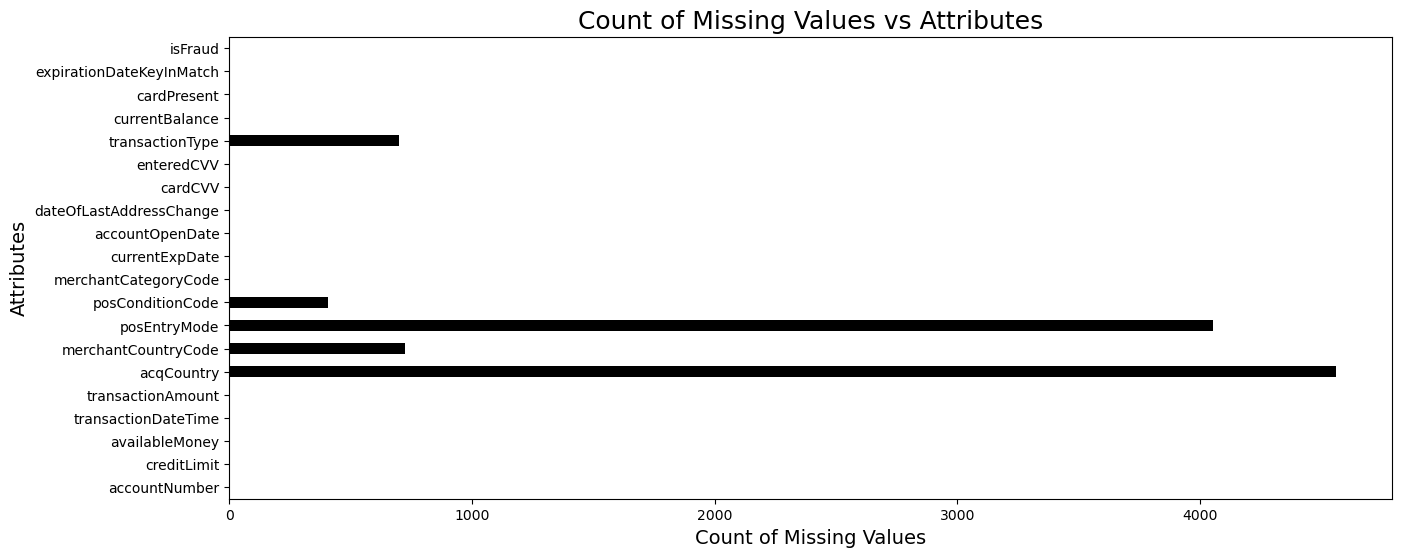

In [126]:

plt.figure(figsize=(15,6))
df.isnull().sum().plot(kind = 'barh', color='black')
plt.xlabel('Count of Missing Values', fontsize=14)
plt.ylabel('Attributes', fontsize=14)
plt.title('Count of Missing Values vs Attributes', fontsize=18)
plt.show()

## Analyze categorical features

In [78]:
# The most null values in categorical features, so let`s analyze them

categorical_columns = ['transactionType', 'acqCountry', 'merchantCountryCode', 'posEntryMode', 'isFraud', 'posConditionCode', 'merchantCategoryCode', 'expirationDateKeyInMatch', 'cardPresent' ]
melted = df[categorical_columns].melt(var_name='column', value_name='value')
value_counts = melted.value_counts().reset_index(name='counts')
sorted_df = value_counts.sort_values(by=['column', 'counts'])

sorted_df

,column,value,counts
41,acqCountry,PR,1538
38,acqCountry,CAN,2424
36,acqCountry,MEX,3130
2,acqCountry,US,774709
7,cardPresent,True,352868
6,cardPresent,False,433495
43,expirationDateKeyInMatch,True,1043
0,expirationDateKeyInMatch,False,785320
30,isFraud,True,12417
3,isFraud,False,773946


In [79]:
# Visualize categorical features

def show_pie_distribution_in_categorical_features(df, categorical_columns, title='Distribution of'):
    num_columns = len(categorical_columns)
    fig, axes = plt.subplots(nrows=num_columns, ncols=1, figsize=(6, 4*num_columns))
    for i, col in enumerate(categorical_columns):
        category_counts = df[col].value_counts()
        colors = plt.cm.Paired(range(len(category_counts)))
        axes[i].pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=90, colors=colors)
        axes[i].set_title(title + ' ' + col)
        axes[i].axis('equal')
    plt.tight_layout()
    plt.show()

In [80]:
fraudDf = df[df['isFraud'] == True]
nonFraudDf = df[df['isFraud'] == False]

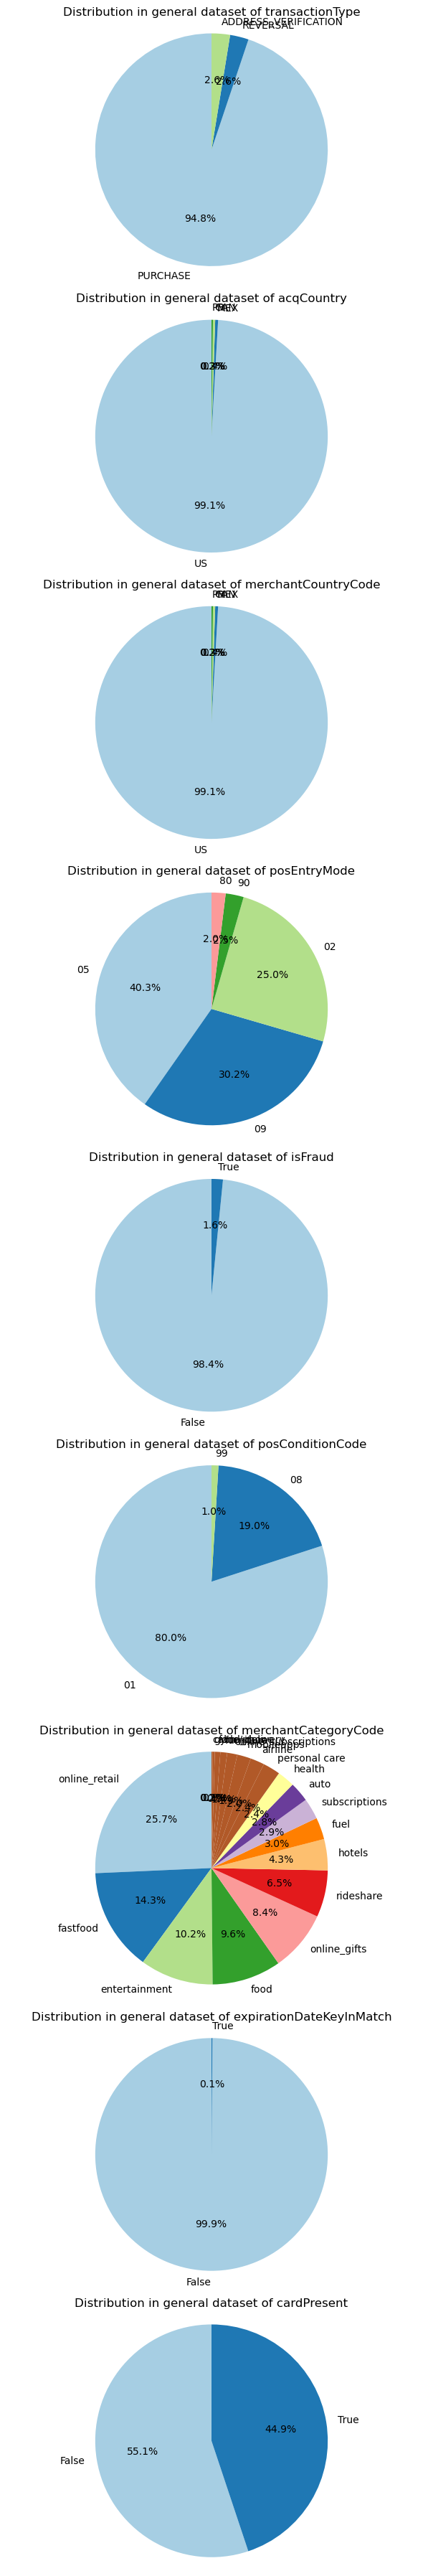

In [81]:
show_pie_distribution_in_categorical_features(df, categorical_columns, title='Distribution in general dataset of')

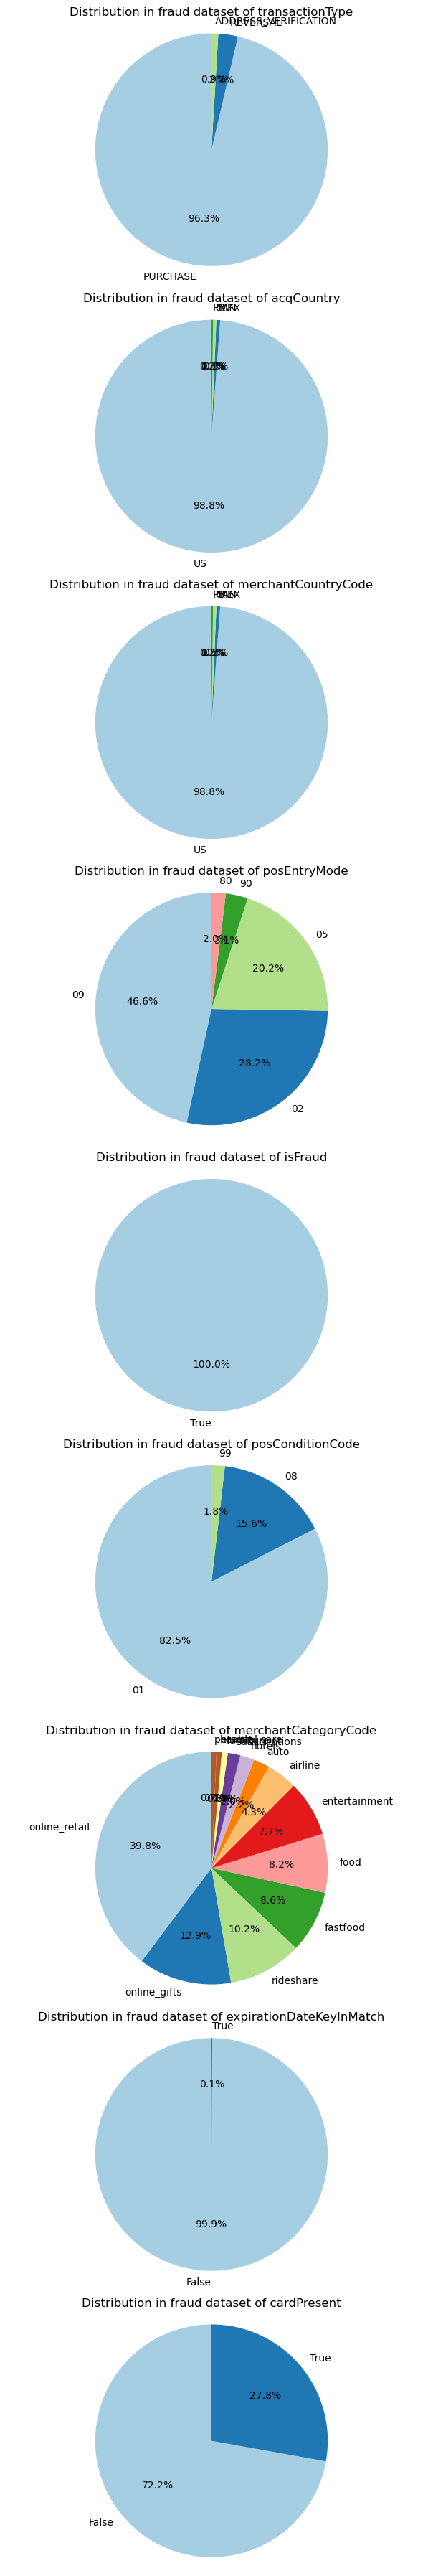

In [82]:
show_pie_distribution_in_categorical_features(fraudDf, categorical_columns, title='Distribution in fraud dataset of')

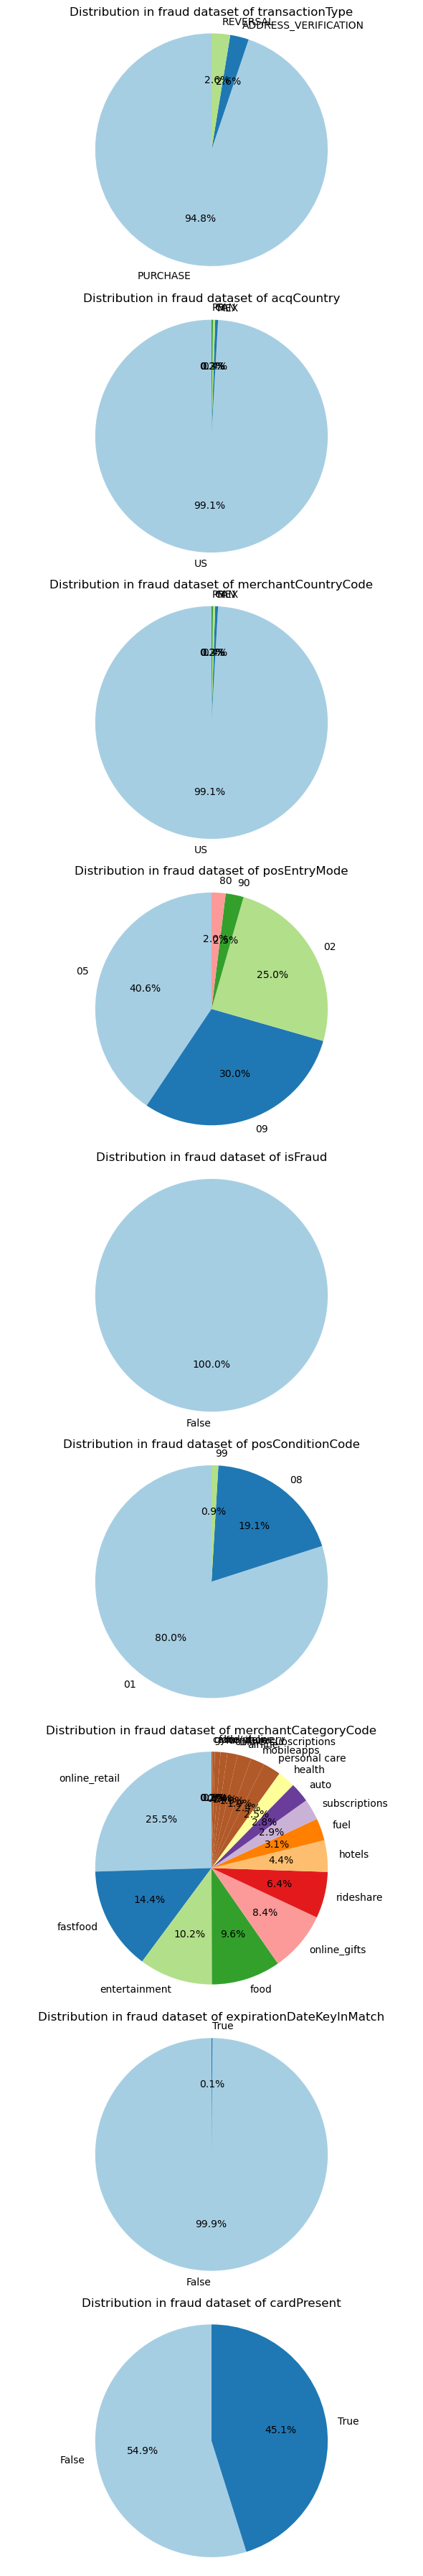

In [83]:
show_pie_distribution_in_categorical_features(nonFraudDf, categorical_columns, title='Distribution in fraud dataset of')

## Analyze discrete features

In [127]:
df.describe()

,creditLimit,availableMoney,transactionDateTime,transactionAmount,dateOfLastAddressChange,currentBalance
count,786363.000000,786363.000000,786363,786363.000000,786363,786363.000000
mean,10759.464459,6250.725369,2016-07-06 01:58:58.395681536,136.985791,2015-04-14 06:46:41.127723520,4508.739089
min,250.000000,-1005.630000,2016-01-01 00:01:02,0.000000,1989-08-22 00:00:00,0.000000
25%,5000.000000,1077.420000,2016-04-06 19:35:07,33.650000,2014-10-08 00:00:00,689.910000
50%,7500.000000,3184.860000,2016-07-08 05:03:57,87.900000,2016-01-13 00:00:00,2451.760000
75%,15000.000000,7500.000000,2016-10-05 13:52:03.500000,191.480000,2016-06-06 00:00:00,5291.095000
max,50000.000000,50000.000000,2016-12-30 23:59:45,2011.540000,2016-12-30 00:00:00,47498.810000
std,11636.174890,8880.783989,NaN,147.725569,NaN,6457.442068


In [131]:
# Define discrete columns

discrete_columns = ["creditLimit", "availableMoney", "transactionAmount", "currentBalance"]

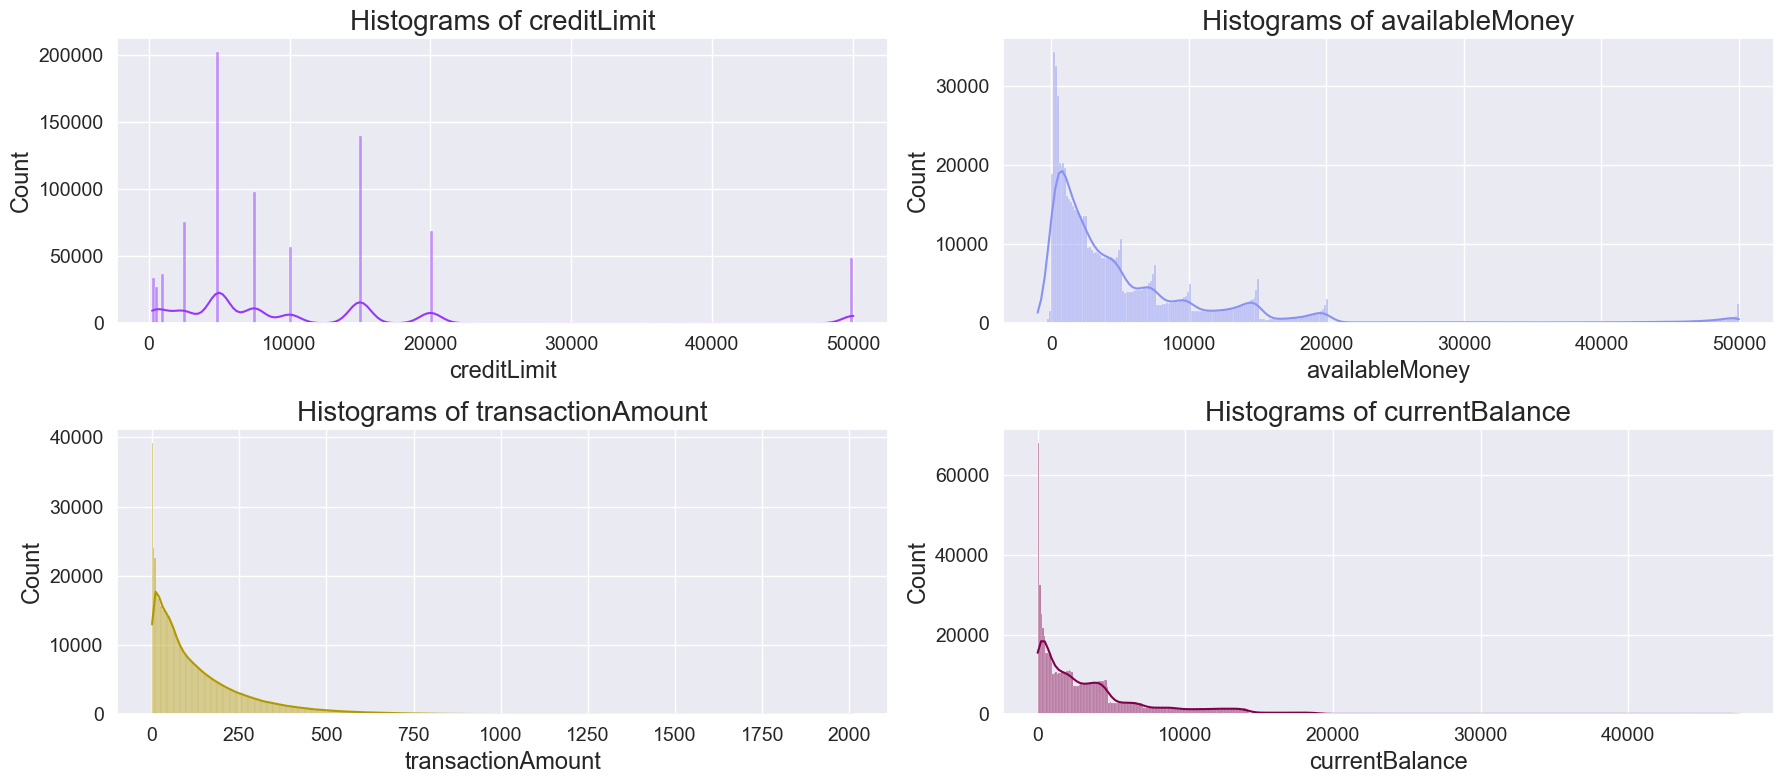

In [132]:
# Visualizing discrete columns statistics using hists to see distribution

fig, axs = plt.subplots(2, 2, figsize=(18, 8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

palette = ["#9736FF", "#8992F3", "#B29800", "#80004C"]
for ax, field, color in itertools.zip_longest(axs.ravel(), discrete_columns, palette): 
    sns.histplot(data = df, x=df[field], ax=ax, color=color, kde=True)
    ax.set_title('Histograms of ' + str(field), fontsize=20)
    ax.set_xlabel(str(field), fontsize=17)
    ax.set_ylabel('Count', fontsize=17)
    ax.xaxis.set_tick_params(labelsize=14)
    ax.yaxis.set_tick_params(labelsize=14)
    plt.tight_layout()

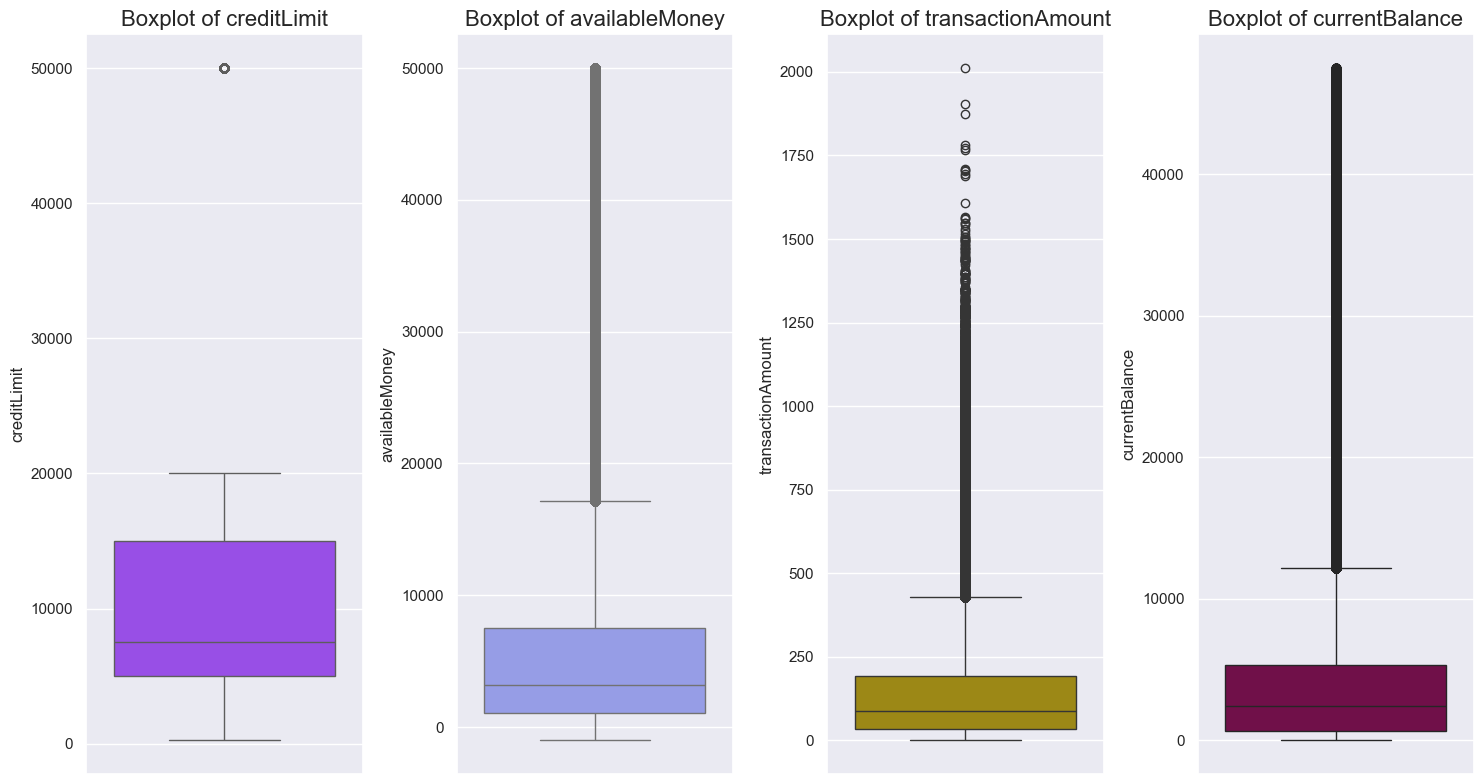

In [133]:
# Visualizing discrete columns statistics using Box-plot to see deviation

fig, axs = plt.subplots(1, 4, figsize=(15, 8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

palette = ["#9736FF", "#8992F3", "#B29800", "#80004C"]
for ax, field, color in itertools.zip_longest(axs.ravel(), discrete_columns, palette): 
    sns.boxplot(data=df, y=df[field], ax=ax, color=color)
    ax.set_title('Boxplot of ' + str(field), fontsize=16)
    plt.tight_layout()
plt.show()

<Axes: >

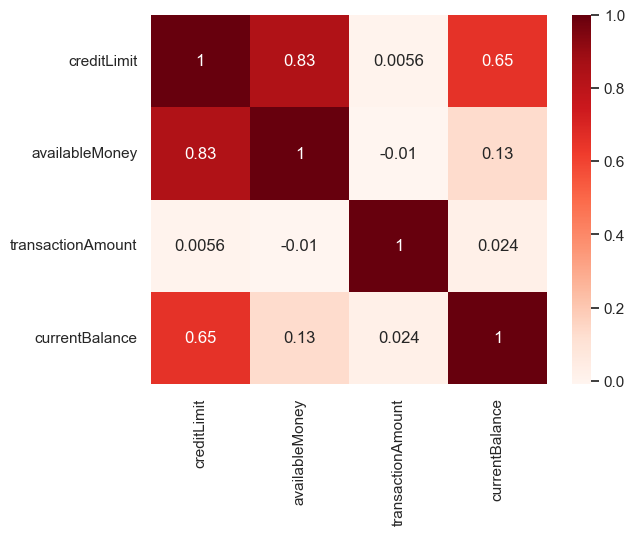

In [206]:
# Check discrete columns correlation

corr = df[discrete_columns].corr()
sns.heatmap(corr, cmap="Reds", annot=True)

In [143]:
# Check records where availableMoney column has negative values

df[df['availableMoney'] < 0].describe()

,creditLimit,availableMoney,transactionDateTime,transactionAmount,dateOfLastAddressChange,currentBalance
count,2931.000000,2931.000000,2931,2931.000000,2931,2931.000000
mean,478.164449,-133.507492,2016-06-29 13:17:44.625042688,139.458987,2014-12-07 01:01:24.749232384,611.671941
min,250.000000,-1005.630000,2016-01-02 10:33:05,0.000000,2003-04-05 00:00:00,250.010000
25%,250.000000,-177.815000,2016-03-30 20:22:55,35.280000,2014-04-24 00:00:00,311.335000
50%,250.000000,-92.220000,2016-06-25 00:55:55,90.540000,2015-08-27 00:00:00,431.070000
75%,500.000000,-39.770000,2016-09-27 04:02:04.500000,195.240000,2016-04-03 00:00:00,634.035000
max,7500.000000,-0.010000,2016-12-30 22:54:31,1338.250000,2016-12-14 00:00:00,7634.540000
std,605.711587,138.852842,NaN,151.290834,NaN,624.484228


In [173]:
# Check transaction with amount 0 grouping by type

df[df['transactionAmount'] == 0].transactionType.value_counts().sort_values(ascending=False)

transactionType
ADDRESS_VERIFICATION    20169
PURCHASE                 1484
REVERSAL                  572
Name: count, dtype: int64

In [190]:
# Check count of frauds by transaction type where amount equals 0

zero_amount_fraud = df[(df['transactionAmount'] == 0) & (df['isFraud'] == True)]

fraud_count_per_transaction_type = zero_amount_fraud.groupby('transactionType').size()

fraud_count_per_transaction_type

transactionType
ADDRESS_VERIFICATION    116
REVERSAL                  6
dtype: int64

In [191]:
zero_amount_fraud

,accountNumber,creditLimit,availableMoney,transactionDateTime,transactionAmount,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud
2031,863358589,2500.0,498.33,2016-09-27 13:31:51,0.0,US,US,05,01,personal care,03/2020,2014-02-15,2016-06-23,240,240,ADDRESS_VERIFICATION,2001.67,False,False,True
2108,863358589,2500.0,1056.83,2016-11-24 21:37:19,0.0,US,US,05,01,personal care,01/2032,2014-02-15,2016-06-23,240,240,ADDRESS_VERIFICATION,1443.17,False,False,True
8650,934061435,5000.0,4054.43,2016-01-04 13:16:48,0.0,US,US,02,01,fastfood,08/2027,2014-12-31,2014-12-31,210,217,ADDRESS_VERIFICATION,945.57,False,False,True
8674,934061435,5000.0,367.22,2016-01-17 19:11:14,0.0,US,US,02,01,fastfood,08/2027,2014-12-31,2014-12-31,210,217,REVERSAL,4632.78,False,False,True
19731,128258324,2500.0,2417.38,2016-04-03 05:43:45,0.0,US,US,05,01,food,11/2031,2013-11-22,2016-02-18,657,657,ADDRESS_VERIFICATION,82.62,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
723934,406723870,7500.0,1376.96,2016-09-04 05:52:39,0.0,US,US,05,08,food,10/2021,2015-04-09,2016-08-19,235,235,ADDRESS_VERIFICATION,6123.04,False,False,True
735283,435257379,10000.0,7498.38,2016-06-14 21:08:25,0.0,US,US,NaN,01,fastfood,02/2026,2014-11-12,2016-03-30,656,656,ADDRESS_VERIFICATION,2501.62,False,False,True
740465,841345961,20000.0,13744.24,2016-12-09 06:48:56,0.0,US,US,09,01,online_retail,02/2025,2015-08-13,2016-09-22,491,491,ADDRESS_VERIFICATION,6255.76,False,False,True
775537,685866922,5000.0,1939.33,2016-02-20 17:06:52,0.0,US,US,05,01,food,03/2027,2012-04-21,2016-02-05,561,561,ADDRESS_VERIFICATION,3060.67,False,False,True


In [194]:
df_574788567 = df[df['accountNumber'] == '574788567']
df_574788567.sort_values('transactionDateTime')

,accountNumber,creditLimit,availableMoney,transactionDateTime,transactionAmount,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud
15,574788567,2500.0,2500.00,2016-01-02 11:19:46,30.08,US,US,02,01,auto,12/2031,2015-10-13,2015-10-13,206,206,PURCHASE,0.00,True,False,False
16,574788567,2500.0,2469.92,2016-01-16 01:01:27,41.25,US,US,09,01,auto,09/2027,2015-10-13,2015-10-13,206,206,PURCHASE,30.08,True,False,False
17,574788567,2500.0,2428.67,2016-01-26 14:04:22,0.00,US,US,09,01,auto,08/2025,2015-10-13,2015-10-13,206,206,ADDRESS_VERIFICATION,71.33,False,False,False
18,574788567,2500.0,2428.67,2016-01-29 07:17:39,124.21,US,US,05,01,auto,08/2032,2015-10-13,2015-10-13,579,579,PURCHASE,71.33,True,False,False
19,574788567,2500.0,2304.46,2016-01-29 07:33:15,196.07,US,US,09,01,auto,08/2022,2015-10-13,2015-10-13,579,539,PURCHASE,195.54,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,574788567,2500.0,2450.80,2016-12-11 21:22:03,1.09,US,US,02,01,auto,11/2028,2015-10-13,2015-10-13,579,579,PURCHASE,49.20,True,False,False
88,574788567,2500.0,2449.71,2016-12-14 19:57:13,66.51,US,US,09,01,auto,05/2031,2015-10-13,2015-10-13,579,579,PURCHASE,50.29,True,False,False
89,574788567,2500.0,2383.20,2016-12-19 11:53:58,34.69,US,US,02,01,auto,02/2021,2015-10-13,2015-10-13,206,206,PURCHASE,116.80,False,False,False
90,574788567,2500.0,2348.51,2016-12-19 18:07:09,41.42,US,US,02,01,gym,10/2029,2015-10-13,2015-10-13,206,206,PURCHASE,151.49,False,False,False


In [192]:
df

,accountNumber,creditLimit,availableMoney,transactionDateTime,transactionAmount,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud
0,737265056,5000.0,5000.00,2016-08-13 14:27:32,98.55,US,US,02,01,rideshare,06/2023,2015-03-14,2015-03-14,414,414,PURCHASE,0.00,False,False,False
1,737265056,5000.0,5000.00,2016-10-11 05:05:54,74.51,US,US,09,01,entertainment,02/2024,2015-03-14,2015-03-14,486,486,PURCHASE,0.00,True,False,False
2,737265056,5000.0,5000.00,2016-11-08 09:18:39,7.47,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,PURCHASE,0.00,False,False,False
3,737265056,5000.0,5000.00,2016-12-10 02:14:50,7.47,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,PURCHASE,0.00,False,False,False
4,830329091,5000.0,5000.00,2016-03-24 21:04:46,71.18,US,US,02,01,fastfood,10/2029,2015-08-06,2015-08-06,885,885,PURCHASE,0.00,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786358,732852505,50000.0,48904.96,2016-12-22 18:44:12,119.92,US,US,90,01,rideshare,12/2022,2012-08-23,2012-08-23,936,936,PURCHASE,1095.04,False,False,False
786359,732852505,50000.0,48785.04,2016-12-25 16:20:34,18.89,US,US,09,01,online_subscriptions,08/2023,2012-08-23,2012-08-23,939,939,PURCHASE,1214.96,False,False,False
786360,732852505,50000.0,48766.15,2016-12-27 15:46:24,49.43,US,US,02,01,rideshare,08/2025,2012-08-23,2012-08-23,936,936,PURCHASE,1233.85,False,False,False
786361,732852505,50000.0,48716.72,2016-12-29 00:30:55,49.89,US,US,09,99,online_retail,07/2022,2012-08-23,2012-08-23,939,939,PURCHASE,1283.28,False,False,False


In [98]:
# Check if dataset contains transactions with expired card
df_copy = df.copy()

df_copy['transactionDateTime'] = pd.to_datetime(df_copy['transactionDateTime'], format='%Y-%m-%dT%H:%M:%S')
df_copy['currentExpDate'] = pd.to_datetime(df_copy['currentExpDate'], format='%m/%Y', errors='coerce')

df_filtered = df_copy[
    (df_copy['transactionDateTime'].dt.year > df_copy['currentExpDate'].dt.year) | 
    ((df_copy['transactionDateTime'].dt.year == df_copy['currentExpDate'].dt.year) & 
     (df_copy['transactionDateTime'].dt.month > df_copy['currentExpDate'].dt.month))
]
print(f'Dataset contains transactions with expired card - {len(df_filtered) > 0}')


Dataset contains transactions with expired card - False


Number of accounts with address changes greater than 0: 5000
Fraud rate among accounts with address changes greater than 0: 1.58%
Number of accounts with address changes greater than 3: 200
Fraud rate among accounts with address changes greater than 3: 1.74%
Number of accounts with address changes greater than 5: 75
Fraud rate among accounts with address changes greater than 5: 1.79%
Number of accounts with address changes greater than 7: 37
Fraud rate among accounts with address changes greater than 7: 1.75%
Number of accounts with address changes greater than 10: 24
Fraud rate among accounts with address changes greater than 10: 1.77%
Number of accounts with address changes greater than 15: 11
Fraud rate among accounts with address changes greater than 15: 1.80%
Number of accounts with address changes greater than 20: 6
Fraud rate among accounts with address changes greater than 20: 1.74%
Number of accounts with address changes greater than 30: 3
Fraud rate among accounts with addres

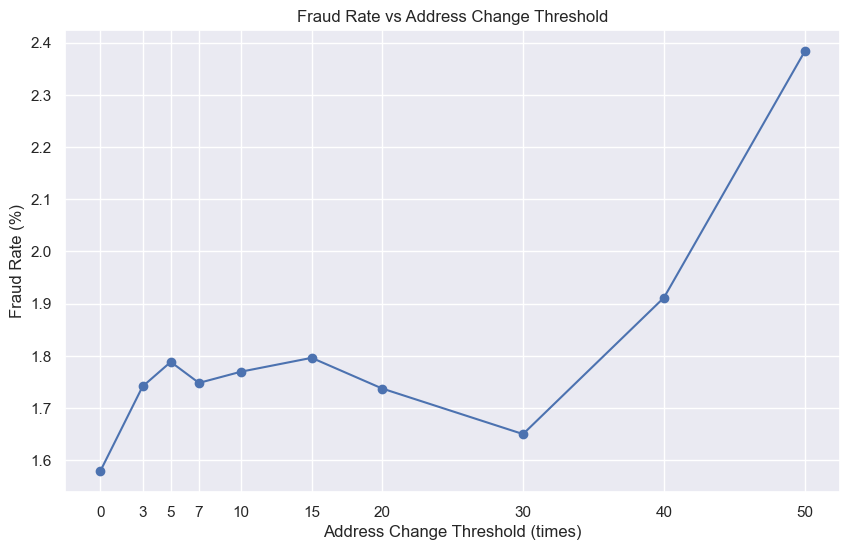

In [158]:
def analyze_fraud_by_address_change(df, threshold):
    """
    Analyze fraud rate based on the frequency of address changes.

    Parameters:
    df (pd.DataFrame): The dataset containing transactions.
    threshold (int): The minimum number of address changes to consider.

    Prints:
    - Number of accounts with frequent address changes.
    - Fraud rate among these accounts.
    """
    
    # Convert columns with dates to datetime format
    df['dateOfLastAddressChange'] = pd.to_datetime(df['dateOfLastAddressChange'])
    df['transactionDateTime'] = pd.to_datetime(df['transactionDateTime'])
    
    # Group by accountNumber and count the number of unique address changes
    address_change_counts = df.groupby('accountNumber')['dateOfLastAddressChange'].nunique()

    # Filter accounts with address changes greater than the threshold
    frequent_address_changers = address_change_counts[address_change_counts > threshold].index
    
    # Filter transactions for accounts with frequent address changes
    frequent_change_transactions = df[df['accountNumber'].isin(frequent_address_changers)]
    
    # Calculate fraud rate among these accounts
    fraud_rate = frequent_change_transactions['isFraud'].mean()

    # Print the results
    print(f"Number of accounts with address changes greater than {threshold}: {len(frequent_address_changers)}")
    print(f"Fraud rate among accounts with address changes greater than {threshold}: {fraud_rate * 100:.2f}%")
    
    return fraud_rate * 100

def visualize_fraud_vs_address_changes(df, thresholds):
    """
    Visualize the fraud rate for different thresholds of address changes.
    
    Parameters:
    df (pd.DataFrame): The dataset containing transactions.
    thresholds (list of int): List of address change thresholds to evaluate.
    """
    
    fraud_rates = []
    
    for threshold in thresholds:
        fraud_rate = analyze_fraud_by_address_change(df, threshold)
        fraud_rates.append(fraud_rate)
    
    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, fraud_rates, marker='o', linestyle='-', color='b')
    plt.title('Fraud Rate vs Address Change Threshold')
    plt.xlabel('Address Change Threshold (times)')
    plt.ylabel('Fraud Rate (%)')
    plt.xticks(thresholds)
    plt.grid(True)
    plt.show()

thresholds = [0, 3, 5, 7, 10, 15, 20, 30, 40, 50]
visualize_fraud_vs_address_changes(df, thresholds)

## Clean/fill N/A

In [134]:
df

,accountNumber,creditLimit,availableMoney,transactionDateTime,transactionAmount,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud
0,737265056,5000.0,5000.00,2016-08-13 14:27:32,98.55,US,US,02,01,rideshare,06/2023,2015-03-14,2015-03-14,414,414,PURCHASE,0.00,False,False,False
1,737265056,5000.0,5000.00,2016-10-11 05:05:54,74.51,US,US,09,01,entertainment,02/2024,2015-03-14,2015-03-14,486,486,PURCHASE,0.00,True,False,False
2,737265056,5000.0,5000.00,2016-11-08 09:18:39,7.47,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,PURCHASE,0.00,False,False,False
3,737265056,5000.0,5000.00,2016-12-10 02:14:50,7.47,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,PURCHASE,0.00,False,False,False
4,830329091,5000.0,5000.00,2016-03-24 21:04:46,71.18,US,US,02,01,fastfood,10/2029,2015-08-06,2015-08-06,885,885,PURCHASE,0.00,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786358,732852505,50000.0,48904.96,2016-12-22 18:44:12,119.92,US,US,90,01,rideshare,12/2022,2012-08-23,2012-08-23,936,936,PURCHASE,1095.04,False,False,False
786359,732852505,50000.0,48785.04,2016-12-25 16:20:34,18.89,US,US,09,01,online_subscriptions,08/2023,2012-08-23,2012-08-23,939,939,PURCHASE,1214.96,False,False,False
786360,732852505,50000.0,48766.15,2016-12-27 15:46:24,49.43,US,US,02,01,rideshare,08/2025,2012-08-23,2012-08-23,936,936,PURCHASE,1233.85,False,False,False
786361,732852505,50000.0,48716.72,2016-12-29 00:30:55,49.89,US,US,09,99,online_retail,07/2022,2012-08-23,2012-08-23,939,939,PURCHASE,1283.28,False,False,False


# Feature engineering

In [123]:
# Creating a new feature
df['cvv_matched_status'] = [True if actual_cvv == entered_cvv else False for actual_cvv, entered_cvv in zip(df['cardCVV'], df['enteredCVV'])]

,accountNumber,creditLimit,availableMoney,transactionDateTime,transactionAmount,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud
0,737265056,5000.0,5000.00,2016-08-13 14:27:32,98.55,US,US,02,01,rideshare,06/2023,2015-03-14,2015-03-14,414,414,PURCHASE,0.00,False,False,False
1,737265056,5000.0,5000.00,2016-10-11 05:05:54,74.51,US,US,09,01,entertainment,02/2024,2015-03-14,2015-03-14,486,486,PURCHASE,0.00,True,False,False
2,737265056,5000.0,5000.00,2016-11-08 09:18:39,7.47,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,PURCHASE,0.00,False,False,False
3,737265056,5000.0,5000.00,2016-12-10 02:14:50,7.47,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,PURCHASE,0.00,False,False,False
4,830329091,5000.0,5000.00,2016-03-24 21:04:46,71.18,US,US,02,01,fastfood,10/2029,2015-08-06,2015-08-06,885,885,PURCHASE,0.00,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786358,732852505,50000.0,48904.96,2016-12-22 18:44:12,119.92,US,US,90,01,rideshare,12/2022,2012-08-23,2012-08-23,936,936,PURCHASE,1095.04,False,False,False
786359,732852505,50000.0,48785.04,2016-12-25 16:20:34,18.89,US,US,09,01,online_subscriptions,08/2023,2012-08-23,2012-08-23,939,939,PURCHASE,1214.96,False,False,False
786360,732852505,50000.0,48766.15,2016-12-27 15:46:24,49.43,US,US,02,01,rideshare,08/2025,2012-08-23,2012-08-23,936,936,PURCHASE,1233.85,False,False,False
786361,732852505,50000.0,48716.72,2016-12-29 00:30:55,49.89,US,US,09,99,online_retail,07/2022,2012-08-23,2012-08-23,939,939,PURCHASE,1283.28,False,False,False


In [84]:


# and also there is a case when available money  decreasing and in some moment available money equals credit limit again
# df_574788567 = df[df['accountNumber'] == '574788567']
# df_574788567.sort_values('transactionDateTime')
# come up smth with account open date
# Find frequent transaction per similar account number (transaction date time)

# fill na with mode
# add feature that indicates about frequent address changing
# replace two cvv columns on matching marker feature
# sample data
# investigate about scaling ??
# divide train test split
# investigate about hyperparameters tuning tools
# build models with benchmarks
# add pipeline to save models
# add controller to test transaction/group of transaction on fraud



# ?? investigate how to process different types of anomalies (point, context, group)
# ?? Model types
# ?? Hybrid - cluster + classifier
# ?? Ensemble